# GRB simulation

The aim of this notebook is to simulate a GRB starting form a fits file and to determine the significance of the simulation. This is an estention of GRB.ipynb where just the flux form one slice was considered.

In the current version of the notebook the aim is to simulate a GW counterpart. This is a preliminary version that will be modified in the future.  The point f these kind of study is to detect the source whith a series of pointings that try to cover, as fast as possible, the GW error box. 

This notebook simulates the source and computes its significance assuming that we know the source position. This can be a nice exercize to become familiar with gammapy, but the correct code must be able to scan the observed region and look for an 'hot-spot', which will than be analysed

# Settings and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from regions import CircleSkyRegion
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle 
from astropy.time import Time
from astropy.wcs import WCS
import pandas as pd

In [2]:
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.datasets import Datasets,  MapDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import (TemplateSpectralModel,
                                     SkyModel,
                                     PointSpatialModel,
                                     FoVBackgroundModel,
                                     Models,
                                     GaussianSpatialModel,
                                     PowerLawSpectralModel)
from gammapy.estimators import TSMapEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.irf import load_cta_irfs
from gammapy.makers import ReflectedRegionsBackgroundMaker, MapDatasetMaker, SafeMaskMaker
import warnings
with warnings.catch_warnings():
    from gammapy.data import Observation
from gammapy.maps import MapAxis, RegionNDMap, Map

#from gammapy.utils.random import get_random_state
#from gammapy.stats import WStatCountsStatistic
#from gammapy.estimators import FluxPoints

In [3]:
%env CALDB=/home/dell/caldb/prod5-v0.1/bcf

env: CALDB=/home/dell/caldb/prod5-v0.1/bcf


In [4]:
run='0004'
ID='000390'
cov='cov'
event_id = f'run{run}_ID{ID}'

# Reading pointing patches
By now I read them and plot pointings but I don't really use them (I just read the t_trigger)

In [5]:
df = pd.read_csv (f'/home/dell/tesi_GW/ScheduledObsCommas/run{run}_MergerID{ID}_{cov}.txt', 
                        header=0,
                        sep=',',
                        #skiprows=9, # 9 for triggered, 11 for non triggered
                        #skipfooter=2, # esclude le ultime n righe, n=2 in questo caso
                        engine='python')

In [6]:
df

,Observation_Time_UTC,RA[deg],DEC[deg],Observatory,PGW,ZenIni[deg],ZenEnd[deg],Duration[s],Delay[s]
0,2016-09-13T08:11:00,3.5156,-20.7424,South,0.5759,38.4663,40.4022,510,79735
1,2016-09-13T08:19:50,3.5156,-16.9578,South,0.1589,41.5248,43.4631,510,80265
2,2016-09-13T08:28:40,2.8125,-23.9695,South,0.1009,42.4251,44.3374,510,80795
3,2016-09-13T08:37:30,0.0000,-20.1055,South,0.0333,47.8438,49.8107,520,81325
4,2016-09-13T08:46:30,6.3281,-20.7424,South,0.0322,43.9935,45.9999,530,81865
5,2016-09-13T08:55:40,0.7031,-16.9578,South,0.0109,52.2533,54.3028,540,82415
6,2016-09-13T09:05:00,6.3281,-23.3180,South,0.0098,47.5789,49.6373,550,82975
7,2016-09-13T09:14:30,0.0000,-23.9695,South,0.0066,55.1921,56.4876,350,83545


In [7]:
# select your pointing 
ii=0

# Reading GRB flux from fits file

In [8]:
# Open fits file
hdul = fits.open(f'/home/dell/tesi_GW/fits/{event_id}.fits') 

## Reading info from fits header
FITS (Flexible Image Transport System) format is a standard widely used in the astronomical community. This is an excellent choice for all types of astronomical images since the format supports 16-bit and floating-point data, and it includes a flexible and highly extensible header. Various standard and widely used non-standard keywords can transfer information about the image between applications. 

Among the information stored in these sources' header youcan find details about the source such as
- the source position 
- the source redshift
- the value of E_iso

In this section information about source position is read from the header.
In this kind of work we don't know a priori where the source is. We assume to detect it at some point while scanning a certain region of the sky. 

Anyway, this notebook represents a preliminary step, what we want to do is to simulate the source in different positions with respect to the center of the camera (quantity that is controlled by the parameter called offset)


In [9]:
#Read trigger time 
hdr=hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
RUN     = '0004    '           / identif. num. of the realization               
MERGERID= '000390  '           / identif. num. for a given realization          
RA      =                4.203 / right ascension of the BNS                     
DEC     =              -22.365 / declination of the BNS                         
EISO    =              4.9E+48 / Eiso prompt emission of the GRB (erg)          
DISTANCE=             339000.0 / distance (kpc)                                 
REDSHIFT=                0.077 / redshift                                       
ANGLE   =                29.84 / viewing angle (deg)                            
N_DET   =                  3

This code is based on the one used to determine the significance of long GRBs. That kind of study assumes that the position of the source is known, and observations are based on visibility tables. These tables tell you when the source is visible from a specific site- La palma or Paranal - according to the site coordinates and the explosion date of the GRB. 
Similar tables have been created for the BNS mergers simulated for this study, in order to keep the structure of the code. Next step will be to compute the visibiliy tables of the regions we decide to point (looking for the source) instead of the source itself.

For consitency the key for the 'explosion time' is GRBJD and is set, if not present in the fits header, to the day you run the visibility tables. 

In [10]:
# GRB explosion date. If not present in the header it is inserted by hand
'GRBJD' in hdr  # Check for existence
False
time = (Time(df['Observation_Time_UTC'][0], scale='utc' ,format='isot') - df['Delay[s]'][0]*u.s)
hdr['GRBJD'] = time.jd

In [11]:
#Reading t_trigger == t_explosion (given in JD)
t_trigger = Time(hdr['GRBJD'] * u.day, format='jd')
trigger=t_trigger.value
t_trigger.isot

'2016-09-12T10:02:05.000'

In [12]:
#checking values
print(t_trigger.isot) # 
print(t_trigger.jd)  # checking if tstart is correct

2016-09-12T10:02:05.000
2457643.918113426


In [13]:
# defining on region and pointing direction
grb_radec = SkyCoord(ra=hdr['RA'] * u.deg, dec=hdr['DEC'] * u.deg, frame='icrs')   # source coordinates
#pointing = SkyCoord(df['RA[deg]'][ii],df['DEC[deg]'][ii] , unit="deg", frame="icrs")
pointing = SkyCoord(grb_radec.ra, grb_radec.dec-0.4*u.deg, unit="deg", frame="icrs")


In [14]:
grb_radec

<SkyCoord (ICRS): (ra, dec) in deg
    (4.203, -22.365)>

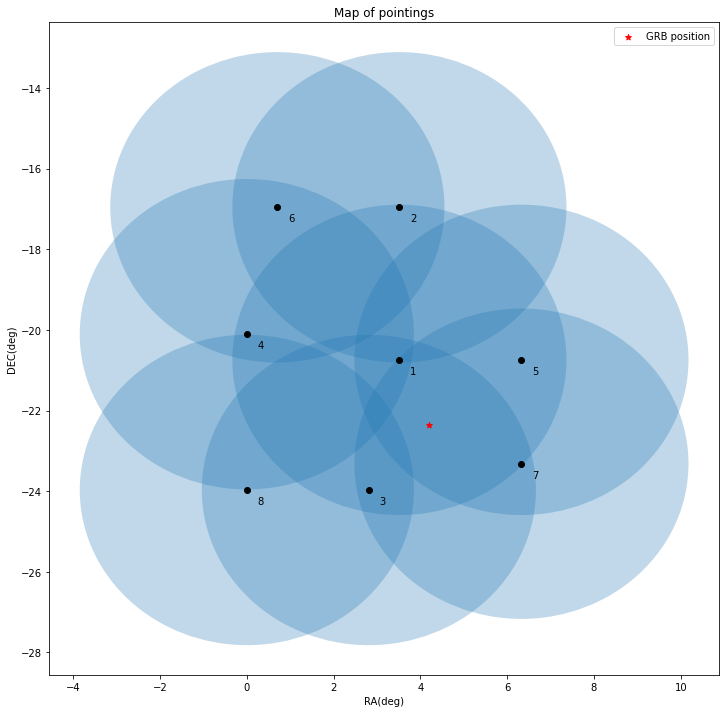

In [15]:
fig, ax = plt.subplots(figsize=(12,12))

for i in range (len(df['RA[deg]'])):
    circle= plt.Circle((df['RA[deg]'][i],df['DEC[deg]'][i]),3.85, alpha=0.15)
    ax.annotate(i+1 ,(df['RA[deg]'][i]+0.25,df['DEC[deg]'][i]-0.35))
    ax.add_patch(circle)

    ax.add_patch(circle)

ax.scatter(df['RA[deg]'],df['DEC[deg]'], color = 'black')

ax.scatter(grb_radec.ra, grb_radec.dec , marker='*', color ='red', label='GRB position')
ax.set_xlabel('RA(deg)');
ax.set_ylabel('DEC(deg)');
ax.set_title('Map of pointings')
plt.legend();

In [16]:
grb_Eval=[]
# reading Energy from Lara's files. 
grb_Eval     = Table.read(hdul,hdu=1)["Energies"].quantity
#print (grb_Eval[0])

In [17]:
# GeV to Tev conversion
grb_Eval     = grb_Eval.to(u.TeV)
#print (grb_Eval[0])

In [18]:
grb_tval=[]
# reading time intervals form Lara's files
grb_tval = Table.read(hdul,hdu=2)["Final Time"].quantity 

In [19]:
print(f'Number of time intervals:    {len(grb_tval)}')
print(f'Number of energy intervals:  {len(grb_Eval)}')

Number of time intervals:    70
Number of energy intervals:  41


## Reading source flux from fits
FLux is stored in the extention number 3 of the fits file, named spectra. If you open it with fitsviewer or a similar application you will se that it is made of 70 rows and 41 columns. This means that rows represnt time intervals, columns energy ones. From the same file you also find out that the flux is reported in units of ph/(GeVscm2)

In [20]:
flux=[]
# reading flux form Lara's files:
# unabsorbed flux, by now will not be considered as a problem: sources are 
# closeby and than only mildly absorbed
flux = Table.read(hdul,hdu=3)

In [21]:
# column number - energy
icol_E  = len(flux.colnames)   
# row number - time
jrow_t  = len(flux[flux.colnames[0]])    
magnify= 1e3       # needed to convert flux from 1/GeV to 1/TeV
flux_unit = u.Unit("1 /(cm2 TeV s)")

In [22]:
flux

col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.6067952066620405e-14,9.28881957961779e-15,5.369829884041887e-15,3.1042774312057286e-15,1.794570513030806e-15,1.03743412037396e-15,5.997365644320139e-16,3.4670533738283214e-16,2.0042898515548152e-16,1.1586720410392304e-16,6.698237271642952e-17,3.8722244913224505e-17,2.2385176731011232e-17,1.2940782188676065e-17,7.48101503361195e-18,4.324745221513823e-18,2.5001181185939087e-18,1.4453084024065575e-18,8.3552707471350515e-19,4.830148993923386e-19,2.792290041767821e-19,1.6142118363563225e-19,9.331694822731155e-20,5.394615892617283e-20,3.1186061247941205e-20,1.802853874158747e-20,1.0422226987012575e-20,6.025047725546383e-21,3.4830534558546896e-21,2.0135364702337707e-21,1.1640091093717628e-21,6.729018591340374e-22,3.889716653982549e-22,2.2484159222782776e-22,1.2989000076293241e-22,7.497178333418057e-23,4.31077868660335e-23,2.447490063378455e-23,1.3045258380239289e-23,6.2764249267205654e-24,0.0
2.4802187920137454e-14,1.43380468036453e-14,8.28876818470553e-15,4.791704125440547e-15,2.7700652152548515e-15,1.6013637519948986e-15,9.257420554870405e-16,5.351678231943033e-16,3.093784032873491e-16,1.7885043209310883e-16,1.0339272786983094e-16,5.977092731204421e-17,3.4553336828867265e-17,1.9975147445446615e-17,1.154755378455911e-17,6.675595200058567e-18,3.859135199234437e-18,2.230950805081705e-18,1.2897038423743408e-18,7.45572693600573e-19,4.3101262722412597e-19,2.4916669618022147e-19,1.4404228220692733e-19,8.327027400312366e-20,4.8138216267596926e-20,2.7828511988156824e-20,1.6087552453696945e-20,9.300148825398962e-21,5.376374470905787e-21,3.108055587179067e-21,1.796741434730183e-21,1.0386779510601668e-21,6.004042559072419e-22,3.4705754411914157e-22,2.0049454596262116e-22,1.1571730030841563e-22,6.651986283949988e-23,3.774370858477443e-23,2.0073586307341833e-23,9.606187092126769e-24,0.0
3.8797019811174886e-14,2.242840380396153e-14,1.2965771588689528e-14,7.495461306986784e-15,4.333096555051555e-15,2.5049459915026378e-15,1.4480993766524704e-15,8.371405258934772e-16,4.839476291421643e-16,2.797682115584534e-16,1.617328972917086e-16,9.349714865981159e-17,5.405033208394194e-17,3.124628333869333e-17,1.806335289421773e-17,1.044235291104193e-17,6.0366829434889285e-18,3.489782549072462e-18,2.017429497924245e-18,1.1662680186697071e-18,6.742149318086568e-19,3.897609871804997e-19,2.2531928612199767e-19,1.3025618871140479e-19,7.530058757431639e-20,4.353097032307959e-20,2.5165080826017087e-20,1.4547831035550635e-20,8.410035927965739e-21,4.861800280926968e-21,2.810567224626663e-21,1.6247601353067445e-21,9.391862146520527e-22,5.428836929720716e-22,3.1362438780596613e-22,1.8101521946500431e-22,1.0406597929139288e-22,5.903994689501433e-23,3.1438578701112757e-23,1.501658659476002e-23,0.0
6.001846970568547e-14,3.469644010819657e-14,2.0057874885597665e-14,1.1595378190722447e-14,6.703242300231108e-15,3.875117878566415e-15,2.240190328830474e-15,1.2950451745334117e-15,7.486604966096159e-16,4.32797673938821e-16,2.50198624630421e-16,1.4463883596519314e-16,8.361513937284221e-17,4.833758157471834e-17,2.794376484949613e-17,1.6154180009128572e-17,9.33866761235768e-18,5.398646834739772e-18,3.1209363965024565e-18,1.804200995022712e-18,1.0430014639480954e-18,6.029550237467704e-19,3.485659155276138e-19,2.0150457785099034e-19,1.1648899903510529e-19,6.734182688060903e-20,3.893004217110804e-20,2.2505299145383426e-20,1.3010212598483222e-20,7.52113943443264e-21,4.3479095298462186e-21,2.513481586257352e-21,1.4529084267236475e-21,8

In [23]:
# Grb fluxval must have the dimension of time x energy, 
# the same as flux in this case
# ----------------------  TRUE
grb_fluxval = np.zeros( (jrow_t,icol_E) )*flux_unit
#print(grb_fluxval.shape)
for i in range(0,icol_E):
    for j in range(0,jrow_t):
        f = flux[j][i] 
        grb_fluxval[j][i] = magnify*f*flux_unit 
# ----------------------        


In [24]:
#checking if we defined grb_fluxval in the correct way
grb_fluxval.shape #70 intervalli temporali, 41 intervalli energetici

(70, 41)

In [25]:
F = [] 
for j in range(0,jrow_t):
    F.append(np.sum(grb_fluxval[j,:].value)) ## Sommo sui bin energetici

In [26]:
len(F)

70

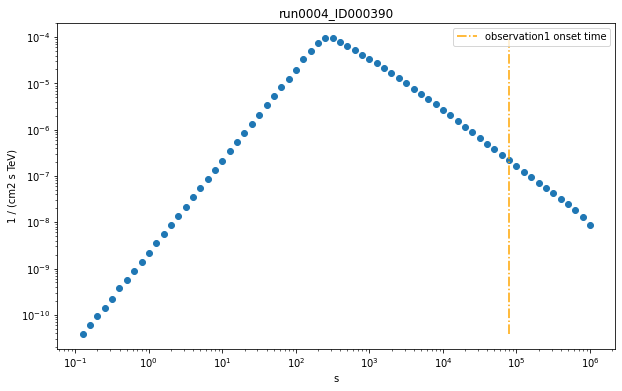

In [27]:
plt.figure(figsize=(10,6))
plt.scatter(grb_tval.value,F)
plt.xlabel(grb_tval.unit)
plt.ylabel(flux_unit)
plt.vlines(df['Delay[s]'][ii], np.min(F), np.max(F), color= 'orange',label=f'observation{ii+1} onset time',linestyle='-.')
plt.xscale('log');
plt.yscale('log');
plt.legend();
plt.title(event_id);


In [28]:
# creating a spectral model for each one of the time intervals
non_absorbed=[]

for i,t in enumerate(grb_tval):

    non_absorbed.append(TemplateSpectralModel(energy = grb_Eval.astype(float),
                                        values = grb_fluxval[i],
                                        interp_kwargs={"values_scale": "log"}))
    

<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde [1 / (cm2 s TeV)]'>

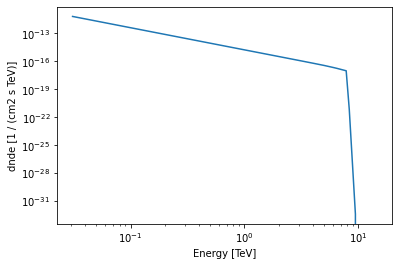

In [29]:
# Checking the shape of the created model for one of the intervals 
non_absorbed[16].plot(energy_bounds=(0.03,15)*u.TeV)

In [30]:
print (f'redshift: {hdr["REDSHIFT"]}')
print (f'Isotropic equivalent energy : {hdr["EISO"]}')

redshift: 0.077
Isotropic equivalent energy : 4.9e+48


# Reading visibility from tables


In [31]:
!pwd

/home/dell/tesi_GW


In [32]:
table = f'visibility/vistable.run{run}_ID{ID}.no.Moon.Th24.npy'
data = np.load(table, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
events = list(data.keys())
sites = list(data[events[0]].keys())

Currently the fits file contains 10 nights of simulation for each event. We don't expect a GRB to be observable for such a long time. A switch will be added to stop observations after a certain time. Right now 3 nights can be considered a reasonable time (because of second the grb observed by HESS, must check again its name)

In [33]:
data[event_id]

{'North': {'night01': {'start': 2457644.36107101,
   'stop': 2457644.73238689,
   'irfs': {'start': array([2457644.46353388, 2457644.53472842, 2457644.62956379]),
    'stop': array([2457644.53472842, 2457644.62956379, 2457644.70232072]),
    'zref': array([60, 40, 60])}},
  'night02': {'start': 2457645.36058993,
   'stop': 2457645.73274611,
   'irfs': {'start': array([2457645.46080221, 2457645.53106448, 2457645.62691839]),
    'stop': array([2457645.53106448, 2457645.62691839, 2457645.69974715]),
    'zref': array([60, 40, 60])}},
  'night03': {'start': 2457646.3597282,
   'stop': 2457646.73352988,
   'irfs': {'start': array([2457646.45804542, 2457646.52702445, 2457646.62441066]),
    'stop': array([2457646.52702445, 2457646.62441066, 2457646.6972245 ]),
    'zref': array([60, 40, 60])}},
  'night04': {'start': 2457647.35805707,
   'stop': 2457647.7344233,
   'irfs': {'start': array([2457647.45528214, 2457647.52421536, 2457647.62199088]),
    'stop': array([2457647.52421536, 2457647.62

In [34]:
s=Time(data[event_id]['North']['night01']['start']*u.day,format='jd')
s.isot

'2016-09-12T20:39:56.535'

In [35]:
# Defining the livetime for each time interval
lvtm=[]
lvtm.append(grb_tval[0])
for i in range(1,len(grb_tval)):
    lvtm.append(grb_tval[i]-grb_tval[i-1])


In [36]:
# Function used to select the apprpriate irf according to the GRB zenith 

def irf_selection(site,z,delta_t):
    if delta_t < 94.9 * 60:   #times are converted in SECONDS
        irf_duration = '0.5h'
    elif 94.9 * 60 < delta_t < 15.8 * 60 * 60:
        irf_duration = '5h'
    elif delta_t > 15.8 * 60 * 60:
        irf_duration = '50h'

    if z == 60:
        energy = 0.110          #energies are in TeV
        #sim_e_max = 5.6234

    elif z == 40:
        energy = 0.04
        #sim_e_max = 5.6234
    else:
        energy = 0.03
        #sim_e_max = 10.


    name = (f'{site}_z{z}_{irf_duration}')
    return [name , energy]


In [37]:
#observation_onset = Time(df['Observation_Time_UTC'][ii], scale='utc' ,format='isot').jd  #  No delayt condition 
observation_onset = (Time(df['Observation_Time_UTC'][0], scale='utc' ,format='isot')- df['Delay[s]'][0]*u.s).jd
observation_onset

2457643.918113426

In [38]:
#observation_onset=observation_onset.jd
observation_onset-trigger

0.0

In [39]:
observation_onset 

2457643.918113426

In [40]:
duration = 0 #df['Duration[s]'][ii]#seconds, 0 means take whole duration

In [70]:
start=[]
stop=[]
z=[]
models=[]
for event in events:
    if event == event_id:
        for site in sites:
            if site == df.Observatory[0]:
                
                for night in data[event][site].keys():
                    if night == 'night01':  # I could also simulate all 10 nights 
                                            # but would not make sense, and would take really ong
                        # start of visibility interval 
                        
                        #print((data[event][site][night]['irfs']['start'][0]  - trigger)*86400)
                        if observation_onset == trigger : 
                            t_obs_start = data[event][site][night]['irfs']['start'][0] 
                            
                        else:
                            t_obs_start = observation_onset
                        
                        t_obs_start =(t_obs_start - trigger)*86400
                        #print('t_obs_start:', t_obs_start)
                       
                        # stop of visibility interval 
                        if duration == 0:
                            t_night_stop = data[event][site][night]['irfs']['stop'][-1]
                            t_night_stop = (t_night_stop - trigger)*86400
                        else:
                            
                            t_night_stop = t_obs_start + duration
                        #print('t_night_stop:', t_night_stop)
                        
                        #print (t_night_stop - t_obs_start)
                        
                        #  ---------------
                        t_obs_stop = t_night_stop
                            
# define simulation intervals                        
                        
                        
                        for j in range(len(lvtm)-1):
                            #if j==0:

                                for i in range(len(data[event][site][night]['irfs']['zref'])):
                                    #if i==0:


                                        #-----------------SIMULATION TIMES
                                        t_min = data[event][site][night]['irfs']["start"][i]
                                        t_max = data[event][site][night]['irfs']["stop"][i]
                                        zenith=data[event][site][night]['irfs']["zref"][i]
                                        #print(t_max)
                                        # converting times from jd to seconds from trigger
                                        if t_max == -9.0:
                                            continue
                                            
                                            
                                        #print('GOT HERE')
                                        t_min = (t_min - trigger) * 86400
                                        t_max = (t_max - trigger) * 86400

                                        #print(zenith_angle, t_min, t_max)
                                        if grb_tval[j+1].value < t_obs_start:
                                            continue

                                        t_slice_start = grb_tval[j].value 

                                        if t_slice_start < t_obs_start:
                                            t_slice_start = t_obs_start

                                        #print('t_slice_start:', t_slice_start)

                                        if t_obs_stop - t_slice_start <= 0:
                                            break

                                        t_slice_stop  = grb_tval[j+1].value   
                                        #print('t_slice_stop:', t_slice_stop)
                                        #print('t_max:',t_max)

                                        if t_slice_stop <= t_min:
                                            #print ('ok')
                                            continue

                                        #print(t_slice_start, t_max)
                                        if t_slice_start >= t_max:
                                            continue
                                        #print('got_here')

                                        t_slice_start= max(t_slice_start, t_min)
                                        t_slice_stop = min (t_slice_stop, t_max)
                                        #print(j,t_slice_start,t_slice_stop, t_slice_stop-t_slice_start)


                                        if t_slice_stop >= t_obs_stop:
                                            t_slice_stop = t_obs_stop


                                        start.append(t_slice_start)
                                        stop.append(t_slice_stop)
                                        z.append(zenith)
                                        #print(night,t_slice_start,t_slice_stop,zenith)

In [71]:
start

[52566.24764800072,
 55805.180633068085,
 61386.64567172527,
 63095.734,
 78612.32166141272,
 79432.82]

In [72]:
if len(start)==0:
    start.append(df['Delay[s]'][ii])
    stop.append(df['Delay[s]'][ii] + df['Duration[s]'][ii])
    if df['ZenIni[deg]'][ii]<33:
        zd=20
    elif df['ZenIni[deg]'][ii]>33 and df['ZenIni[deg]'][ii]< 54:
        zd=40
    elif df['ZenIni[deg]'][ii]>54 and df['ZenIni[deg]'][ii]< 80:
        zd=60
    z.append(zd)
z

[60, 40, 20, 20, 40, 40]

In [73]:
# spatial model
spatial_model=PointSpatialModel(lon_0=grb_radec.ra, lat_0=grb_radec.dec, frame="icrs")

In [74]:
#print(start,stop)

In [75]:
#print(grb_tval)

In [76]:
# spectral models
for i in range(len(start)):
    for j in range(len(grb_tval)-1):
        #print(start[i],stop[i])
        #print(grb_tval[j],grb_tval[j+1])
        if stop[i] <= grb_tval[j+1].value and start[i]>=grb_tval[j].value:
            
            model = SkyModel(spectral_model=non_absorbed[i],spatial_model=spatial_model, name=f"{event_id}")
            models.append (model)

print(start)

[52566.24764800072, 55805.180633068085, 61386.64567172527, 63095.734, 78612.32166141272, 79432.82]


In [77]:
print(len(start))
print(len(models))

6
6


In [78]:
name_irf=[]
sim_e_min=[]

In [79]:
for event in events:
    if event == event_id:
        for site in sites:
            if site == 'North':
                first_night_start = data[event][site]['night01']['irfs']['start'][0]
                first_night_start  = (first_night_start - trigger)*86400
                for i in range(len(start)):
                    t_start=start[i]
                    t_stop = stop[i]
                    zenith_angle = z[i]
                    # ----------------------------------------time selection for IRF
                    delta_t_irf = t_stop - first_night_start
                    #print(delta_t_irf)
                    name_irf.append(irf_selection(site, zenith_angle, delta_t_irf)[0])
                    sim_e_min.append(irf_selection(site, zenith_angle, delta_t_irf)[1])
                    
print(name_irf)

['North_z60_5h', 'North_z40_5h', 'North_z20_5h', 'North_z20_5h', 'North_z40_5h', 'North_z40_5h']


# Spectrum simulation

In [80]:
#select IRF according to observational conditions
import os
irfs=[]
for i in range(len(name_irf)):
    path = f"$CALDB/{name_irf[i]}"
# iterate through all file
    if '$' in path:
        path= os.path.expandvars(path)
    for file in os.listdir(path):
        # Check whether file is in text format or not
        if file.endswith(".gz"):
            file_path = f"{path}/{file}"
    irfs.append(load_cta_irfs(file_path))
print(len(irfs))

6


In [81]:
n_obs = len(start)

In [82]:
# from SoHappy
maker=[]
empty=[]
erec_edges = np.asarray([3.00000000e+01, # LST 20°
                        #3.16227766e+01, # too close fro previous edge
                        4.00000000e+01, # LST 40°
                        5.62341325e+01,
                        #1.00000000e+02, # too close from next edge
                        1.10000000e+02, # LST 60, MST 20° and 40°
                        # 1.77827941e+02,  # too close from next edge
                        2.0e+02, # too close from next edge
                        #2.5e+02, # MST 60°
                        3.16227766e+02,
                        5.62341325e+02,
                        1.00000000e+03,
                        1.77827941e+03,
                        3.16227766e+03,
                        5.62341325e+03,
                        1.00000000e+04])*u.GeV
                        #1.5e+04])*u.GeV


In [83]:
print(sim_e_min)

[0.11, 0.04, 0.03, 0.03, 0.04, 0.04]


In [84]:
energy_axis      = MapAxis.from_edges(erec_edges.to("TeV").value,
                                       unit="TeV",
                                       name="energy",
                                       interp="log")


energy_axis_true  = MapAxis.from_energy_bounds(0.015*u.TeV,
                                                 20.0*u.TeV,
                                                 nbin = 24,
                                                 per_decade=True,
                                                 name="energy_true")


geom              = WcsGeom.create(skydir=pointing,
                                    binsz=0.02,
                                    width=(2, 2),
                                    frame="icrs",
                                    axes=[energy_axis])

In [85]:
datasets = Datasets()
# -------------------
stacked = MapDataset.create(geom=geom,energy_axis_true=energy_axis_true, name=event_id)
# --------------
#factors=[]
#ns=[]
#nb=[]
# --------------
for idx in range(n_obs):
    print(idx)
    irf   = irfs[idx]

    bkg_model = FoVBackgroundModel(dataset_name=f"{event_id}")

    model = Models([models[idx], bkg_model])
 
    
    # -------------- cannot be moved outside cycle, it's  IRF dependent
    eirf_min    = min(irf["aeff"].axes["energy_true"].edges)

    empty = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name=f"dataset-{idx}")
    
    maker =  MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    
    #-----------------------
    with warnings.catch_warnings(): # because of t_trig
        warnings.filterwarnings("ignore")
        obs = Observation.create(
            pointing=pointing,
            livetime=(stop[idx]-start[idx])*u.s,
            reference_time = t_trigger+start[idx]*u.s,
            deadtime_fraction = 0 ,
            irfs=irf,
            obs_id=idx)

    # -----------------
    dataset = maker.run(empty, obs)
    # -----------------
    dataset.models = model
    #-----------------------
    dataset.mask_fit = dataset.counts.geom.energy_mask(energy_min=eirf_min , energy_max=None)
    
    dataset.fake(random_state=42)
   
    datasets.append(dataset)
    #ns.append(dataset.counts.data[dataset.mask_safe].sum())
    #nb.append(dataset.background.data[dataset.mask_safe].sum())
    stacked.stack(dataset)

0
1
2
3
4
5


In [86]:
table=datasets.info_table(cumulative=True) #cumulative=True

In [87]:
table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
stacked,28493,-21.80078125,-0.1291196201459932,28514.80078125,28514.80346733326,28514.80078125,nan,672.0655517578125,5983538176.0,3238.9329850673676,3238.9329850673676,8.79703289057318,8.803763743403573,-0.006730852830394872,110000,110000,cash,nan
stacked,164423,322.421875,0.7956596259037867,164100.578125,164100.54010602366,164100.578125,nan,1685423.0,15539643392.0,8820.398023724556,8820.398023724556,18.64122226205045,18.604668143502426,0.03655411854802581,110000,110000,cash,nan
stacked,201772,241.78125,0.5384752246561958,201530.21875,201530.2070219135,201530.21875,nan,6558895.0,17011156992.0,10529.486726999283,10529.486726999283,19.162567486088797,19.139605184481063,0.022962301607735002,110000,110000,cash,nan
stacked,542001,651.875,0.8858057196984153,541349.125,541349.1373243742,541349.125,nan,50804496.0,31523590144.0,26046.074013412,26046.074013233185,20.809316587248638,20.78428882300039,0.025027764248244388,110000,110000,cash,nan
stacked,561765,484.125,0.6461077843702056,561280.875,561280.8059619237,561280.875,nan,51052260.0,32767029248.0,26866.572664499283,26866.57266432047,20.909440404443554,20.891420800452913,0.018019603990638854,110000,110000,cash,nan
stacked,676123,626.125,0.7616970988399916,675496.875,675496.8948180117,675496.875,nan,52472044.0,40063963136.0,31568.34383904934,31568.343838453293,21.41775328624148,21.397919334761724,0.019833951479757302,110000,110000,cash,nan


In [88]:
#stacked= datasets.stack_reduce(name=event_id)
print(stacked)

MapDataset
----------

  Name                            : run0004_ID000390 

  Total counts                    : 676123 
  Total background counts         : 675496.88
  Total excess counts             : 626.12

  Predicted counts                : 675496.89
  Predicted background counts     : 675496.88
  Predicted excess counts         : nan

  Exposure min                    : 5.25e+07 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 110000 
  Number of fit bins              : 110000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [89]:
stacked.counts.smooth(0.05 * u.deg).plot_interactive(add_cbar=True, stretch="linear")

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [90]:
# file = stacked.to_hdulist()
stacked.write(f'{event_id}_sim.fits', overwrite=True)

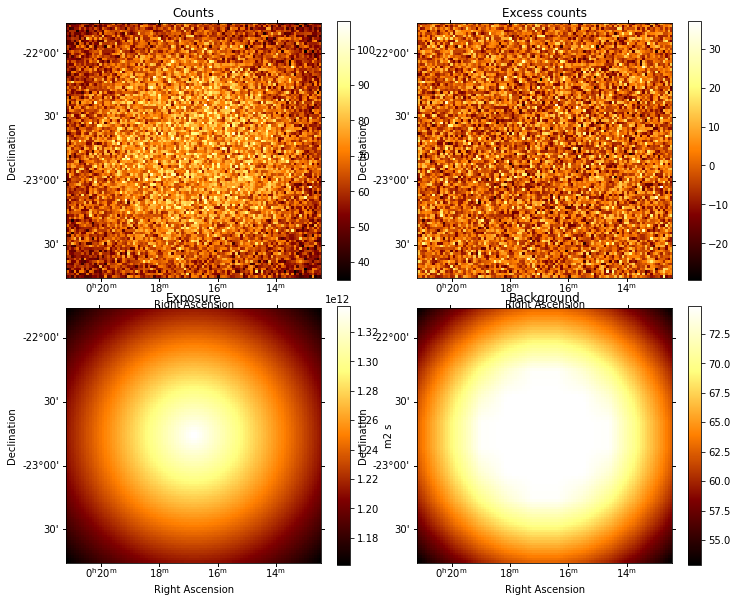

In [91]:
stacked.peek()

In [92]:
spatial_model = PointSpatialModel()   #(sigma="0.05 deg")
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)


In [93]:
ts_image_estimator = TSMapEstimator(
    model,
    kernel_width="0.5 deg",
    selection_optional=[],
    downsampling_factor=2,
    sum_over_energy_groups=False,
    energy_edges=[0.11, 10] * u.TeV,
)


In [94]:
images_ts = ts_image_estimator.run(stacked)

In [95]:
sources = find_peaks(
    images_ts["sqrt_ts"],
    threshold=5,
    min_distance="0.2 deg",
)
sources

<Table length=0>
<No columns>

In [96]:
if len(sources)>0:
    source_pos = SkyCoord(sources["ra"], sources["dec"])
    print(source_pos)
    images_ts["sqrt_ts"].plot(add_cbar=True)

    plt.gca().scatter(
        source_pos.ra.deg,
        source_pos.dec.deg,
        transform=plt.gca().get_transform("icrs"),
        color="none",
        edgecolor="white",
        marker="o",
        s=200,
        lw=1.5,
    );
else:
    print('No source detected')


No source detected


In [97]:
print(grb_radec)
print(f'\tAngular distance of src from camera center: {pointing.separation(grb_radec)}')
print(f"\tPointing delay: {df['Delay[s]'][ii]}")
print(f"\tExposure time: {df['Duration[s]'][ii]}")


<SkyCoord (ICRS): (ra, dec) in deg
    (4.203, -22.365)>
	Angular distance of src from camera center: 0.3999999999999989 deg
	Pointing delay: 79735
	Exposure time: 510


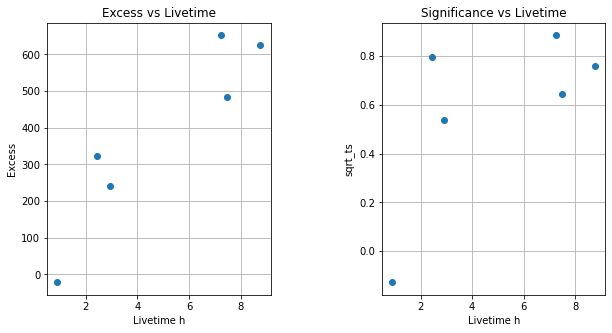

In [98]:
# Plot temporal evolution of excess events and significance value
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(
    (table["livetime"].to("h")), table["excess"], marker="o", ls="none"
)
plt.plot(table["livetime"].to("h")[-1:1], table["excess"][-1:1], 'r')
plt.xlabel("Livetime h")
plt.ylabel("Excess")
plt.grid()
plt.title('Excess vs Livetime')

plt.subplot(122)
plt.plot(
    (table["livetime"].to("h")),
    table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.grid()
plt.xlabel("Livetime h")
plt.ylabel("sqrt_ts")
plt.title('Significance vs Livetime')
plt.subplots_adjust(wspace=0.5)
